# Exploration_SSAC 05 2차원 Spectrogram 모델 생성

* Keyword : 음성/오디오 데이터, Wav 파일 형태, 1차원/2차원 데이터 활용  

##### 음성/오디오 데이터   
* 소리 : 공기의 압축 현상
* 물리량 3요소 : 진폭(Amplitude - 소리의 세기/크기), 주파수(Frequency - 소리의 높이), 위상(Phase)  
* 주파수(Frequency) : 1초동안의 진동 횟수  

##### 아날로그 신호 -> 디지털 신호
* 표본화(Sampling)  
* 양자화(Quantizing)  
* 부호화(Encoding)  


##### Process of Project  
1) Data Load   
2) 데이터 처리와 분류  
3) 학습을 위한 하이퍼파라미터 설정  
4) 데이터셋 구성  
5) 2차원 Spectrogram 데이터를 처리하는 모델 구성  
6) 학습 과정 시각화  
7) 모델 성능 평가

##### 필요한 모듈 import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import IPython.display as ipd
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
import librosa
import librosa.display
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D
from keras import regularizers, optimizers
import pandas as pd

## 1) Data Load

#### 1차원 Waveform Data

In [2]:
data_path = os.getenv("HOME")+'/aiffel/speech_recognition/data/speech_wav_8000.npz'
speech_data = np.load(data_path)

print("✅")

✅


In [3]:
print("Wave data shape : ", speech_data["wav_vals"].shape)
print("Label data shape : ", speech_data["label_vals"].shape)
print("✅")

Wave data shape :  (50620, 8000)
Label data shape :  (50620, 1)
✅


In [4]:
rand = random.randint(0, len(speech_data["wav_vals"]))
print("rand num : ", rand)

sr = 8000 # 1초동안 재생되는 샘플의 갯수
data = speech_data["wav_vals"][rand]
print("Wave data shape : ", data.shape)
print("label : ", speech_data["label_vals"][rand])

ipd.Audio(data, rate=sr)

rand num :  43060
Wave data shape :  (8000,)
label :  ['unknown']


#### 2차원 Spectrogram Data 변환

In [5]:
def wav2spec(wav, fft_size=258): # spectrogram shape을 맞추기위해서 size 변형
    D = np.abs(librosa.stft(wav, n_fft=fft_size))
    return D
print("✅")

✅


In [6]:
spec = wav2spec(data)
print("Waveform shape : ",data.shape)
print("Spectrogram shape : ",spec.shape)
# print(spec)

Waveform shape :  (8000,)
Spectrogram shape :  (130, 126)


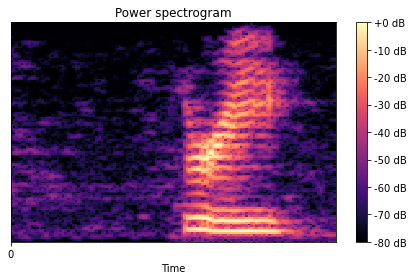

In [7]:
librosa.display.specshow(librosa.amplitude_to_db(spec, ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

In [8]:
total_data = speech_data["wav_vals"]

spec_data = []
for i in range(len(total_data)):
    Spec = wav2spec(total_data[i])
    spec_data.append(Spec)

spec_data = np.array(spec_data)

* for문을 통해 모든 데이터가 wac-> spectrogram 형식으로 변환된 것을 알 수 있고, 그래서 shape도 정확하게 변형된 것을 알 수 있음

In [9]:
spec_data[0].shape

(130, 126)

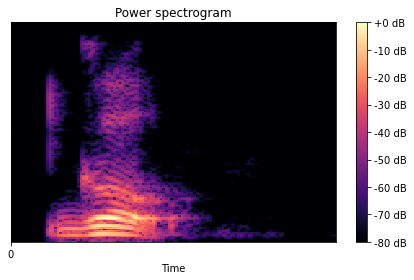

In [10]:
librosa.display.specshow(librosa.amplitude_to_db(spec_data[2645], ref=np.max), x_axis='time')
plt.title('Power spectrogram')
plt.colorbar(format='%+2.0f dB')
plt.xticks(range(0, 1))
plt.tight_layout()
plt.show()

## 2) 데이터 처리와 분류

##### 라벨 데이터 처리

In [11]:
target_list = ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go']

label_value = target_list
label_value.append('unknown')
label_value.append('silence')

print('LABEL : ', label_value)

new_label_value = dict()
for i, l in enumerate(label_value):
    new_label_value[l] = i
label_value = new_label_value

print('Indexed LABEL : ', new_label_value)

LABEL :  ['yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go', 'unknown', 'silence']
Indexed LABEL :  {'yes': 0, 'no': 1, 'up': 2, 'down': 3, 'left': 4, 'right': 5, 'on': 6, 'off': 7, 'stop': 8, 'go': 9, 'unknown': 10, 'silence': 11}


* Text로 이루어진 라벨 데이터를 학습에 사용하기 위해 index를 추가하여 dict형태로 변환하여 라벨 데이터 정제 과정을 거침

In [12]:
temp = []
for v in speech_data["label_vals"]:
    temp.append(label_value[v[0]])
label_data = np.array(temp)

label_data

array([ 3,  3,  3, ..., 11, 11, 11])

In [13]:
del speech_data

##### Train / Test Data 분리

In [14]:
# sr = sampling rate, 앞에서 8000으로 resize
sr = 130
sc = 126
train_spec, test_spec, train_label, test_label = train_test_split(spec_data, 
                                                                label_data, 
                                                                test_size=0.3,
                                                                shuffle=True)
print(train_spec)

# reshape 과정 개중요!!!!!! (2차원 spectrogram 데이터를 cnn으로 넣기 위한 과정)
# 3dim -> 4dim 변환
train_spec = train_spec.reshape([-1, sr, sc, 1]) # add channel for CNN
test_spec = test_spec.reshape([-1, sr, sc, 1])
print("✅")

[[[2.9034523e-04 5.2580304e-05 2.0367243e-05 ... 1.0081044e-03
   1.0915903e-03 2.9824418e-03]
  [3.6802268e-04 2.3472053e-04 2.2552822e-04 ... 1.2311069e-03
   2.1821228e-03 4.0638880e-03]
  [4.0192809e-04 3.7773370e-04 8.3142651e-05 ... 2.6788339e-03
   3.3873946e-03 5.2257613e-03]
  ...
  [5.9001421e-04 3.3756977e-04 7.4582240e-05 ... 6.1219711e-05
   2.5860351e-04 6.1870110e-04]
  [5.1617296e-04 2.2910086e-04 4.4811353e-05 ... 3.8753635e-05
   3.1783796e-04 5.8524788e-04]
  [4.8673264e-04 2.6101706e-04 6.7678099e-07 ... 1.0053404e-06
   3.4833181e-04 6.4428657e-04]]

 [[3.9390681e-04 3.4491901e-04 1.8248694e-04 ... 1.6949269e-04
   2.6438935e-04 6.0557085e-04]
  [2.5972060e-04 1.5539829e-04 1.5407118e-04 ... 1.9046468e-04
   3.7584273e-04 8.1492920e-04]
  [2.4379414e-04 1.6494982e-04 1.2524950e-04 ... 8.3848764e-04
   1.0941767e-03 1.7366325e-03]
  ...
  [1.4193820e-04 7.3767944e-05 4.2833190e-06 ... 1.1328808e-05
   1.4869890e-05 2.2717029e-05]
  [1.4888949e-04 7.5513584e-05 1.741

In [15]:
print("train data : ", train_spec.shape)
print("train labels : ", train_label.shape)
print("test data : ", test_spec.shape)
print("test labels : ", test_label.shape)
print("✅")

train data :  (35434, 130, 126, 1)
train labels :  (35434,)
test data :  (15186, 130, 126, 1)
test labels :  (15186,)
✅


In [16]:
train_spec[0].shape

(130, 126, 1)

## 3) Hyper-parameters Setting

In [17]:
batch_size = 16
max_epochs = 10

# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav'

checkpoint_dir

'/home/ssac22/aiffel/speech_recognition/models/wav'

## 4) 데이터셋 구성

In [18]:
def one_hot_label(spec, label):
    label = tf.one_hot(label, depth=12)
    return spec, label
print("✅")

✅


In [19]:
# for train
train_dataset = tf.data.Dataset.from_tensor_slices((train_spec, train_label))
train_dataset = train_dataset.map(one_hot_label)
train_dataset = train_dataset.repeat().batch(batch_size=batch_size)
print(train_dataset)

# for test
test_dataset = tf.data.Dataset.from_tensor_slices((test_spec, test_label))
test_dataset = test_dataset.map(one_hot_label)
test_dataset = test_dataset.batch(batch_size=batch_size)
print(test_dataset)
print("✅")

tf.config.list_physical_devices('GPU')

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>
✅


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [20]:
del spec_data # 메모리 공간 확보를 위한 불필요 데이터 삭제

## 5) 모델 구성 | 시각화 | 성능 평가

### Model 01 : Conv layer model

#### Model

In [ ]:
# input_tensor = layers.Input(shape=(130, 126, 1))

# x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(input_tensor)
# x = layers.Conv2D(32, (3,3), padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)

# x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
# x = layers.Conv2D(64, (3,3), padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)

# x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
# x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
# x = layers.Conv2D(128, (3,3), padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)

# x = layers.Conv2D(256,(3,3), padding='same', activation='relu')(x)
# x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
# x = layers.Conv2D(256, (3,3), padding='same', activation='relu')(x)
# x = layers.MaxPool2D()(x)
# x = layers.Dropout(0.3)(x)

# x = layers.Flatten()(x)
# x = layers.Dense(256)(x)
# x = layers.BatchNormalization()(x)
# x = layers.Activation('relu')(x)

# output_tensor = layers.Dense(12)(x)

# model_wav = tf.keras.Model(input_tensor, output_tensor)

# model_wav.summary()

In [21]:
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(130, 126, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(128, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(12, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 130, 126, 32)      320       
_________________________________________________________________
activation (Activation)      (None, 130, 126, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 124, 64)      18496     
_________________________________________________________________
activation_1 (Activation)    (None, 128, 124, 64)      0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 62, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 62, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 62, 64)        3

#### Loss

In [22]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


#### Training

In [23]:
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")


✅


In [24]:
train_spec.shape

(35434, 130, 126, 1)

In [25]:
train_dataset

<BatchDataset shapes: ((None, 130, 126, 1), (None, 12)), types: (tf.float32, tf.float32)>

In [26]:
#30분 내외 소요 (메모리 사용량에 주의해 주세요.)
history_spec = model.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
2212/2214 [============================>.] - ETA: 0s - loss: 2.3289 - accuracy: 0.2871
Epoch 00001: val_loss improved from inf to 2.25902, saving model to /home/ssac22/aiffel/speech_recognition/models/wav
2214/2214 [==============================] - 58s 26ms/step - loss: 2.3289 - accuracy: 0.2872 - val_loss: 2.2590 - val_accuracy: 0.3583
Epoch 2/10
2214/2214 [==============================] - ETA: 0s - loss: 2.2209 - accuracy: 0.3958
Epoch 00002: val_loss improved from 2.25902 to 2.12814, saving model to /home/ssac22/aiffel/speech_recognition/models/wav
2214/2214 [==============================] - 62s 28ms/step - loss: 2.2209 - accuracy: 0.3958 - val_loss: 2.1281 - val_accuracy: 0.4903
Epoch 3/10
2214/2214 [==============================] - ETA: 0s - loss: 2.1010 - accuracy: 0.5169
Epoch 00003: val_loss improved from 2.12814 to 2.01887, saving model to /home/ssac22/aiffel/speech_recognition/models/wav
2214/2214 [==============================] - 61s 27ms/step - loss: 2.1010 

#### 학습 결과 시각화

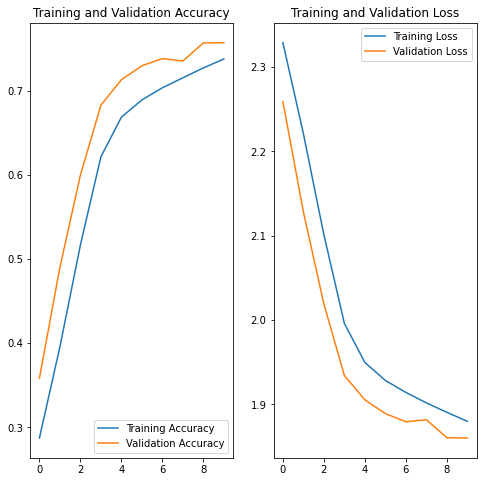

✅


In [27]:
acc = history_spec.history['accuracy']
val_acc = history_spec.history['val_accuracy']

loss=history_spec.history['loss']
val_loss=history_spec.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")


#### 모델 평가

In [28]:
model.load_weights(checkpoint_dir)
print("✅")

✅


In [29]:
results = model.evaluate(test_dataset)
print("✅")

950/950 [==============================] - 32s 34ms/step - loss: 1.8602 - accuracy: 0.7576
✅


In [30]:
# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

loss value: 1.860
accuracy value: 75.7606%
✅


#### Model Test

In [47]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(sr*sc,), rate=sr*sc)


label :  on


In [48]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: on(Correct!)
✅


### Model 02 : Skip-Connection model

In [38]:
input_tensor = layers.Input(shape=(130, 126, 1))

x = layers.Conv2D(32, 3, padding='same', activation='relu')(input_tensor)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
skip_1 = layers.MaxPool2D()(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(skip_1)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_1], -1)
skip_2 = layers.MaxPool2D()(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(skip_2)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_2], -1)
skip_3 = layers.MaxPool2D()(x)

x = layers.Conv2D(256, 3, padding='same', activation='relu')(skip_3)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
x = tf.concat([x, skip_3], -1)
x = layers.MaxPool2D()(x)


x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.BatchNormalization()(x)
x = layers.Activation('relu')(x)

output_tensor = layers.Dense(12)(x)

model_wav_skip = tf.keras.Model(input_tensor, output_tensor)

model_wav_skip.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 130, 126, 1) 0                                            
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 130, 126, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_7 (Conv2D)               (None, 130, 126, 32) 9248        conv2d_6[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_3 (MaxPooling2D)  (None, 65, 63, 32)   0           conv2d_7[0][0]                   
______________________________________________________________________________________________

In [39]:
optimizer=tf.keras.optimizers.Adam(1e-4)
model_wav_skip.compile(loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
             optimizer=optimizer,
             metrics=['accuracy'])
print("✅")

✅


In [40]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/speech_recognition/models/wav_skip'

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)
print("✅")

✅


In [42]:
#30분 내외 소요
history_wav_skip = model_wav_skip.fit(train_dataset, epochs=max_epochs,
                    steps_per_epoch=len(train_spec) // batch_size,
                    validation_data=test_dataset,
                    validation_steps=len(test_spec) // batch_size,
                    callbacks=[cp_callback]
                    )
print("✅")

Epoch 1/10
2213/2214 [============================>.] - ETA: 0s - loss: 0.7951 - accuracy: 0.7470
Epoch 00001: val_loss improved from inf to 0.30971, saving model to /home/ssac22/aiffel/speech_recognition/models/wav_skip
2214/2214 [==============================] - 71s 32ms/step - loss: 0.7948 - accuracy: 0.7471 - val_loss: 0.3097 - val_accuracy: 0.9041
Epoch 2/10
2213/2214 [============================>.] - ETA: 0s - loss: 0.2734 - accuracy: 0.9171
Epoch 00002: val_loss improved from 0.30971 to 0.21877, saving model to /home/ssac22/aiffel/speech_recognition/models/wav_skip
2214/2214 [==============================] - 71s 32ms/step - loss: 0.2734 - accuracy: 0.9171 - val_loss: 0.2188 - val_accuracy: 0.9329
Epoch 3/10
2213/2214 [============================>.] - ETA: 0s - loss: 0.1634 - accuracy: 0.9534
Epoch 00003: val_loss improved from 0.21877 to 0.19319, saving model to /home/ssac22/aiffel/speech_recognition/models/wav_skip
2214/2214 [==============================] - 71s 32ms/step 

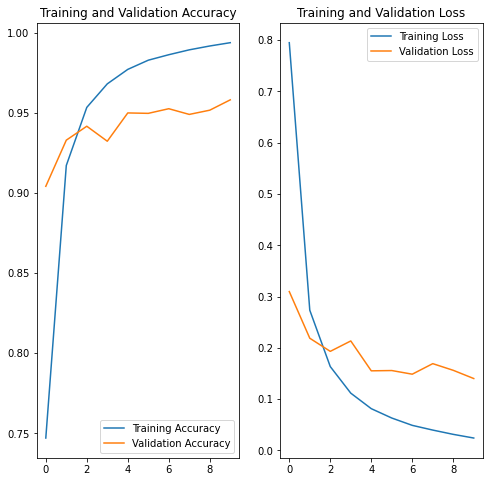

✅


In [43]:
acc = history_wav_skip.history['accuracy']
val_acc = history_wav_skip.history['val_accuracy']

loss=history_wav_skip.history['loss']
val_loss=history_wav_skip.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()
print("✅")

In [44]:
# Evaluation 

model_wav_skip.load_weights(checkpoint_dir)
results = model_wav_skip.evaluate(test_dataset)

# loss
print("loss value: {:.3f}".format(results[0]))
# accuracy
print("accuracy value: {:.4f}%".format(results[1]*100))
print("✅")

950/950 [==============================] - 36s 38ms/step - loss: 0.1402 - accuracy: 0.9581
loss value: 0.140
accuracy value: 95.8053%
✅


In [45]:
inv_label_value = {v: k for k, v in label_value.items()}
batch_index = np.random.choice(len(test_spec), size=1, replace=False)

batch_xs = test_spec[batch_index]
batch_ys = test_label[batch_index]
y_pred_ = model(batch_xs, training=False)

print("label : ", str(inv_label_value[batch_ys[0]]))

ipd.Audio(batch_xs.reshape(sr*sc,), rate=sr*sc)

label :  no


In [46]:
if np.argmax(y_pred_) == batch_ys[0]:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Correct!)')
else:
    print("y_pred: " + str(inv_label_value[np.argmax(y_pred_)]) + '(Incorrect!)')
print("✅")

y_pred: no(Correct!)
✅


## Result of Project

어렴풋이 기억나는 중학교?고등학교? 때 배운 주파수 관련 기억을 더듬으며 프로젝트를 시작하게 되었다. 다양한 특성을 가진 음성과 오디오 데이터의 개념을 시작으로 wav data 형태의 1차원 데이터 정제 및 전처리, spectrogram 형태의 2차원 데이터 정제 및 전처리 과정을 거치게 되었다.  

Spectrogram은 wav 데이터를 해석하는 방법 중 하나인데, 이와 관련하여 **푸리에변환과 STFT(Short Time Fourier Transform)** 개념을 중요하게 짚고 넘어가야 한다.  

결과적으로, Conv2D 모델에 적용하였을 때, Evaluate Accuracy 는 **75%** 에 도달하였고, Skip-Connection 을 적용한 Conv2D 모델에 적용하였을 때는 **95%** 에 도달하였다. 

## Good  

음성 데이터를 처음 접하고, **소리**에 대한 근본적인 개념들에 대하여 집중할 수 있었고, 새로운 모델을 접하게 되면서 신기함을 많이 느꼈다. 다시 한번, 모델 네트워크 구조에 데이터를 입력할 때, 데이터 형태, 즉, **차원과 배열 구조**가 가장 중요한 것 같다. (여기서 Error를 만나 해결하기까지 오래 걸렸다. 항상 데이터 변환할 때 주의하자!)

## Difficulties / Challenges  

* 푸리에변환 이해도 향상 필요  
* 음성 데이터 양방향 변환 과정 숙지  